<a href="https://colab.research.google.com/github/jg4726/public-file/blob/main/lstm_stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

Weijie Zou (wz2212)

In [ ]:
import datatable as dt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
#import janestreet
from tqdm import tqdm
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
from sklearn.metrics import roc_auc_score

## Data

In [ ]:
#load data
data_df = dt.fread("jane_street_train.jay").to_pandas()

In [ ]:
data_df

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,...,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,...,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,...,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,...,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,...,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390486,499,0.000000,0.000142,0.000142,0.005829,0.020342,0.015396,1,-1.649365,-1.169996,...,-1.896874,-1.260055,1.947725,-1.994399,-1.685163,-2.866165,-0.216130,-1.892048,0.901585,2390486
2390487,499,0.000000,0.000012,0.000012,-0.000935,-0.006326,-0.004718,1,2.432943,5.284504,...,-0.936553,1.064936,3.119762,-0.419796,-0.208975,-0.146749,0.730166,0.648452,2.068737,2390487
2390488,499,0.000000,0.000499,0.000499,0.007605,0.024907,0.016591,1,-0.622475,-0.963682,...,-2.956745,-0.640334,-2.279663,-0.950259,-4.388417,-1.669922,-3.288939,-1.336142,-2.814239,2390488
2390489,499,0.283405,-0.000156,-0.000156,-0.001375,-0.003702,-0.002004,-1,-1.463757,-1.107228,...,-2.035894,-1.780962,0.881246,-2.202140,-1.912601,-3.341684,-0.571188,-2.185795,0.627452,2390489


## Preprocessing

In [ ]:
#ignore unrelated columns
ignore_columns = ['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp','ts_id','date','weight']
features_columns = [col for col in data_df.columns if col not in ignore_columns]

In [ ]:
dataset=data_df.sort_values(by=['date', 'ts_id'])
dataset['action'] = dataset["resp"]*dataset["weight"]
#dataset['action'] = (dataset['resp'] > 0).astype('int')
dataset.drop(columns=ignore_columns,inplace=True)

NaN Values Distribution:

In [ ]:
nan_stat=pd.DataFrame(columns=('feature_name','number'))
for i in features_columns:
    d=dataset[i].isna().value_counts()
    num=d[True] if True in d else 0
    row=pd.DataFrame({'feature_name':i,'number':num},index=[0])
    nan_stat=nan_stat.append(row,ignore_index=True)

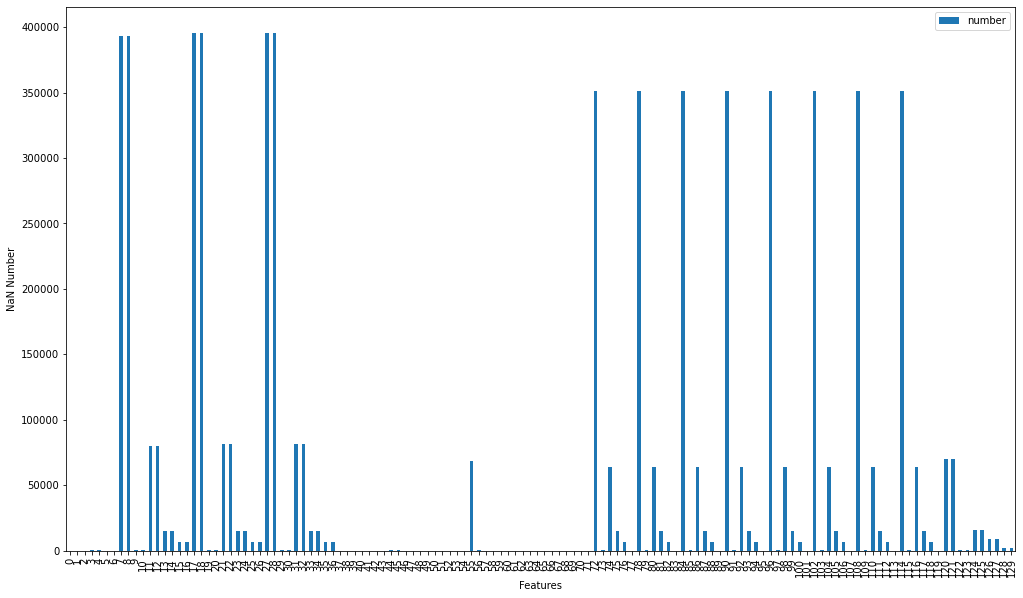

In [ ]:
ax=nan_stat.plot.bar(y="number",figsize=(17,10))
ax.set_ylabel('NaN Number')
ax.set_xlabel('Features')
plt.show()

Split into Train and Test Set:

In [ ]:
data=dataset[:int(len(dataset)*0.01)] # due to weak GPU, we just 1 % data
data_train,data_test=data[:int(len(data)*0.8)].copy(deep=True),data[int(len(data)*0.8):].copy(deep=True)

Fill NaN Values:

In [ ]:
data_train.fillna(data_train.mean(),inplace=True)
data_test.fillna(data_train.mean(),inplace=True)

Outliers Distribution

In [ ]:
outlier_stat=pd.DataFrame(columns=('sigma','percent'))
for sigma in range(10):
    outliers={}
    for i in features_columns:
        mean = np.mean(data_train[i])
        std = np.std(data_train[i])
        low, high = mean - sigma * std, mean + sigma * std
        outliers[i]=[low,high]
    
    s=set()
    for i in features_columns:
        for j in data_train[(data_train[i]<outliers[i][0]) | (data_train[i]>outliers[i][1])].index.values:
            s.add(j)
            
    row=pd.DataFrame({'sigma':sigma,'percent':len(s)*100/len(data_train)},index=[0])
    outlier_stat=outlier_stat.append(row,ignore_index=True)

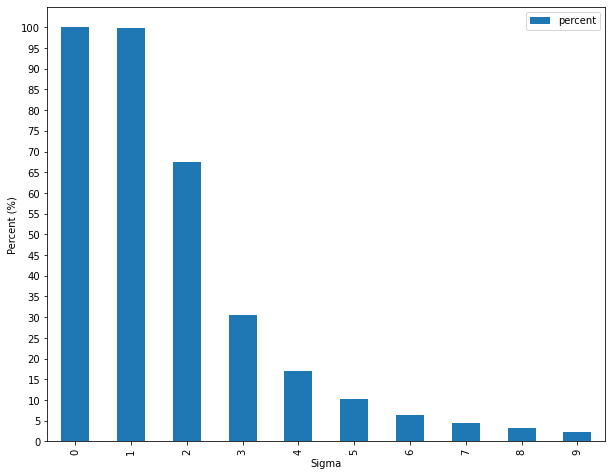

In [ ]:
ax=outlier_stat.plot.bar(y="percent",figsize=(10,8))
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Sigma')
ax.set_yticks(range(0,105,5))
plt.show()

Drop Outliers:

In [ ]:
outliers={}
sigma=6
for i in features_columns:
    mean = np.mean(data_train[i])
    std = np.std(data_train[i])
    low, high = mean - sigma * std, mean + sigma * std
    outliers[i]=[low,high]

In [ ]:
def drop_outlier(df,features):
    for i in features:
        index=df[(df[i]<outliers[i][0]) | (df[i]>outliers[i][1])].index
        df.drop(index=index,inplace=True)

In [ ]:
drop_outlier(data_train,features_columns)
#drop_outlier(data_test,features_columns)

In [ ]:
X_train,Y_train=data_train[features_columns].to_numpy(),data_train["action"].to_numpy()
x_test,y_test=data_test[features_columns].to_numpy(),data_test["action"].to_numpy()

In [ ]:
data_Train,data_valid=data_train[:int(len(data_train)*0.8)],data_train[int(len(data_train)*0.8):]

Standardization Features Data:

In [ ]:
sc = StandardScaler()
sc.fit(X_train)
#sc.fit(x_test)
X_train = sc.transform(X_train)
x_test=sc.transform(x_test)

Normalization Targets Data:

In [ ]:
minn=Y_train.min()*(-1)
maxn=Y_train.max()
Y_train=np.frompyfunc(lambda x: x/maxn if x>=0 else x/minn, 1, 1)(Y_train).astype(np.float64)

PCA:

In [ ]:
pca = PCA()
X_train=pca.fit_transform(X_train)

Component Ratio Chart:

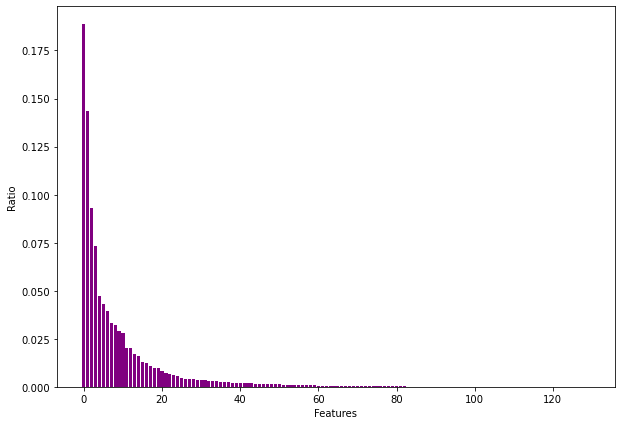

In [ ]:
ax=plt.figure(figsize=(10,7))
ecr=pca.explained_variance_ratio_
plt.bar(np.array(range(len(ecr))), ecr, color='purple')
plt.ylabel('Ratio')
plt.xlabel('Features')
plt.show()

Keep 99% of Components

In [ ]:
index=-1
sumr=0
for i in range(len(ecr)):
    sumr+=ecr[i]
    if sumr >0.99:
        index=i
        break;

In [ ]:
X_train=X_train[:,:index+1]
x_test=pca.transform(x_test)[:,:index+1]

split into train and valid set:

In [ ]:
x_train, x_valid, y_train, y_valid=train_test_split(X_train,Y_train,test_size=0.2, shuffle=False)

## LSTM Model

In [ ]:
#LSTM NN model
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.to(device) for t in (h0, c0)]


## Dataset

In [ ]:
#Dataset class
class Timeseries_Dataset(Dataset):
    """
    Custom Dataset subclass.
    Serves as input to DataLoader to transform X
      into sequence data using rolling window.
    DataLoader using this dataset will output batches
      of `(batch_size, seq_len, n_features)` shape.
    Suitable as an input to RNNs.
    """

    def __init__(self, X: np.ndarray, y: np.ndarray, w: np.ndarray=None, r: np.ndarray=None, seq_len: int = 32):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float().unsqueeze(1)
        self.seq_len = seq_len
        self.w = torch.tensor(w).float().unsqueeze(1) if w is not None else None
        self.r = torch.tensor(r).float().unsqueeze(1) if r is not None else None
    def __len__(self):
        return self.X.__len__() - self.seq_len

    def __getitem__(self, index):
        return {'x': self.X[index:index + self.seq_len],
                'y': self.y[index + self.seq_len-1],
                'w': self.w[index + self.seq_len-1] if self.w is not None else [],
                'r': self.r[index + self.seq_len-1] if self.r is not None else []}

In [ ]:
seq_dim = 24
batch_size = 380
train_dataset = Timeseries_Dataset(X=x_train, y=y_train, w=data_df.loc[data_Train.index]["weight"].values,
                                  r=data_df.loc[data_Train.index]["resp"].values, seq_len=seq_dim)
validation_dataset = Timeseries_Dataset(X=x_valid, y=y_valid, w=data_df.loc[data_valid.index]["weight"].values,
                                  r=data_df.loc[data_valid.index]["resp"].values, seq_len=seq_dim)
test_dataset = Timeseries_Dataset(X=x_test, y=y_test,w=data_df.loc[data_test.index]["weight"].values,
                                  r=data_df.loc[data_test.index]["resp"].values, seq_len=seq_dim)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Parameters of the Model

In [ ]:
#parameters of the model
dropout=0.0
lr = 0.007
input_dim = x_train.shape[1]
hidden_dim = 140
layer_dim = 1
output_dim = 1
num_epochs = 100
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.L1Loss()
patience = 20
model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Training

In [ ]:
weight = 'C:\\Users\\55373\\Desktop\\lstm\\best_30.pth'

#training
phase_training = True
if os.path.exists(weight):
    phase_training = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
if phase_training:  
    print('Start model training ...')
    best, best_auc, best_acc = float("-inf"), 0, 0
    trials = 0
    for epoch in range(1, num_epochs + 1):
        #train
        model.train()
        for train_batch in train_loader:
            optimizer.zero_grad()
            features = train_batch['x'].to(device)
            targets = train_batch['y'].to(device)
            preds = model(features)
            loss = criterion(preds, targets)
            
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch} loss: {loss.item():.4f}')
        #
        model.eval()
        correct, total, auc, score = 0, 0, 0, 0
        with torch.no_grad():
            for valid_batch in validation_loader:
                features = valid_batch['x'].to(device)
                targets = valid_batch['y'].to(device)
                outputs = model(features)
                
                probas= torch.sigmoid(outputs)
                preds = torch.where(probas>0.5,torch.ones_like(probas),torch.zeros_like(probas))
                targets= torch.where(targets>0,torch.ones_like(targets),torch.zeros_like(targets))
#                 probas= F.softmax(outputs, 1)
#                 preds = torch.argmax(probas,1)
                total += targets.size(0)
                correct += (preds == targets).sum().item()
                
                weights=valid_batch['w'].to(device)
                resps=valid_batch['r'].to(device)
                score+=(weights*resps*preds).sum().item()
                
                auc+=roc_auc_score(targets.cpu().detach().numpy(), probas.cpu().detach().numpy())*targets.size(0)
                #auc+=roc_auc_score(targets.cpu().detach().numpy(), probas[:,1].cpu().detach().numpy())*targets.size(0)
                
        test_acc = correct / total  
        test_auc = auc / total 
        
        if score > best:
            trials = 0
            best = score
            best_auc = test_auc
            torch.save(model.state_dict(), 'best.pth')
            print(f'Epoch {epoch} best model saved with loss: {loss.item():.4f}, accuracy: {test_acc:2.2%}, auc: {test_auc:.2}, score:{score:.5}')
        else:
            trials += 1
            if trials >= patience:
                print(f'Early stopping on epoch {epoch}')
                break
    print('Training Complete !!!')

Start model training ...
Epoch 1 loss: 0.0161
Epoch 1 best model saved with loss: 0.0161, accuracy: 56.71%, auc: 0.51, score:-1.4158
Epoch 2 loss: 0.0146
Epoch 2 best model saved with loss: 0.0146, accuracy: 58.81%, auc: 0.48, score:-1.0592
Epoch 3 loss: 0.0108
Epoch 3 best model saved with loss: 0.0108, accuracy: 59.38%, auc: 0.54, score:2.4819
Epoch 4 loss: 0.0166
Epoch 5 loss: 0.0187
Epoch 6 loss: 0.0103
Epoch 7 loss: 0.0109
Epoch 8 loss: 0.0110
Epoch 9 loss: 0.0112
Epoch 10 loss: 0.0117
Epoch 11 loss: 0.0088
Epoch 12 loss: 0.0107
Epoch 12 best model saved with loss: 0.0107, accuracy: 58.25%, auc: 0.52, score:3.3901
Epoch 13 loss: 0.0081
Epoch 14 loss: 0.0117
Epoch 15 loss: 0.0054
Epoch 16 loss: 0.0067
Epoch 17 loss: 0.0053
Epoch 18 loss: 0.0059
Epoch 19 loss: 0.0084
Epoch 20 loss: 0.0053
Epoch 21 loss: 0.0052
Epoch 22 loss: 0.0052
Epoch 23 loss: 0.0041
Epoch 24 loss: 0.0045
Epoch 25 loss: 0.0046
Epoch 26 loss: 0.0047
Epoch 27 loss: 0.0041
Epoch 28 loss: 0.0059
Epoch 29 loss: 0.0043

## Testing

In [ ]:
#test
if phase_training:
    model.load_state_dict(torch.load('best.pth'))
else:
    model.load_state_dict(torch.load(weight))
    
model.eval()
correct, total, auc, score = 0, 0, 0, 0
with torch.no_grad():   
    for idx,test_batch in enumerate(test_loader):
        features = test_batch['x'].to(device)
        targets = test_batch['y'].to(device)
        outputs = model(features)
        
        probas= torch.sigmoid(outputs)
        preds = torch.where(probas>0.5,torch.ones_like(probas),torch.zeros_like(probas))
        targets= torch.where(targets>0,torch.ones_like(targets),torch.zeros_like(targets))
#         probas= F.softmax(outputs, 1)
#         preds = torch.argmax(probas,1)      
        total += targets.size(0)
        correct += (preds == targets).sum().item()
        
        weights=test_batch['w'].to(device)
        resps=test_batch['r'].to(device)
        score+=(weights*resps*preds).sum().item()
        
        auc+=roc_auc_score(targets.cpu().detach().numpy(), probas.cpu().detach().numpy())*targets.size(0)
        #auc+=roc_auc_score(targets.cpu().detach().numpy(), probas[:,1].cpu().detach().numpy())*targets.size(0)
        
test_acc = correct / total
test_auc = auc / total
print(f'Test accuracy: {test_acc:2.2%}')
print(f'Auc score: {test_auc:.2}')
print(f'Model score: {score:.5}')


Test accuracy: 56.70%
Auc score: 0.56
Model score: 7.2518


## Baseline

### Predict 1 All the Time

In [ ]:
correct, total, auc, score = 0, 0, 0, 0 
for idx,test_batch in enumerate(test_loader):
    targets = test_batch['y'].to(device)
    targets= torch.where(targets>0,torch.ones_like(targets),torch.zeros_like(targets))
    probas = torch.tensor([[1]]* targets.size(0)).float().to(device)
    preds = torch.where(probas>0.5,torch.ones_like(probas),torch.zeros_like(probas))
#     probas = torch.tensor([[0,1]]* targets.size(0)).float().to(device)
#     preds = torch.argmax(probas,1)
    total += targets.size(0)
    correct += (preds == targets).sum().item()

    weights=test_batch['w'].to(device)
    resps=test_batch['r'].to(device)
    score+=(weights*resps*preds).sum().item()
    
    auc+=roc_auc_score(targets.cpu().detach().numpy(), probas.cpu().detach().numpy())*targets.size(0)
    #auc+=roc_auc_score(targets.cpu().detach().numpy(), probas[:,1].cpu().detach().numpy())*targets.size(0)
    
test_acc = correct / total
test_auc = auc / total
print(f'Test accuracy: {test_acc:2.2%}')
print(f'Auc score: {test_auc:.2}')
print(f'Model score: {score:.5}')

Test accuracy: 39.31%
Auc score: 0.5
Model score: 2.5315


### Randomly Predict

In [ ]:
correct, total, auc, score = 0, 0, 0, 0 
for idx,test_batch in enumerate(test_loader):
    targets = test_batch['y'].to(device)
    targets= torch.where(targets>0,torch.ones_like(targets),torch.zeros_like(targets))
    rand=random.choice([0,1])
    probas = torch.tensor([[rand]]* targets.size(0)).float().to(device)
    preds = torch.where(probas>0.5,torch.ones_like(probas),torch.zeros_like(probas))
#     probas = torch.tensor([[rand,1-rand]]* targets.size(0)).float().to(device)
#     preds = torch.argmax(probas,1)
    total += targets.size(0)
    correct += (preds == targets).sum().item()

    weights=test_batch['w'].to(device)
    resps=test_batch['r'].to(device)
    score+=(weights*resps*preds).sum().item()
    
    auc+=roc_auc_score(targets.cpu().detach().numpy(), probas.cpu().detach().numpy())*targets.size(0)
    #auc+=roc_auc_score(targets.cpu().detach().numpy(), probas[:,1].cpu().detach().numpy())*targets.size(0)
    
test_acc = correct / total
test_auc = auc / total
print(f'Test accuracy: {test_acc:2.2%}')
print(f'Auc score: {test_auc:.2}')
print(f'Model score: {score:.5}')

Test accuracy: 46.12%
Auc score: 0.5
Model score: 1.1776
